분류 성능비교
==

다루는 내용
--
- 분류 알고리즘 비교
- 리지 규제, 라쏘 규제
- 교차검증
- 정적 성능평가 Confusion matrix  
- 동적 성능평가 ROC

데이터
--
- 포도주 품질 분류 https://goo.gl/Gyc8K7

출처
--
https://www.kaggle.com/vishalyo990/prediction-of-quality-of-wine/notebook



모듈 불러오기
--

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC 
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score 
%matplotlib inline

데이터 읽기 (포도주 품질 평가)
--

In [4]:
wine = pd.read_csv('data/winequality-red.csv')
print(wine.shape)
wine.head(5)

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


- fixed acidity - 결합 산도 
- volatile acidity - 휘발성 산도 
- citric acid - 시트르산 
- residual sugar - 잔류 설탕 
- chlorides	 - 염화물 
- free sulfur dioxide - 자유 이산화황 
- total sulfur dioxide - 총 이산화황 
- density - 밀도 
- pH - pH 
- sulphates - 황산염 
- alcohol - 알코올 
- quality - 품질 (0 ~ 10 점)

In [5]:
wine.info() # 데이터 정보

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [10]:
wine.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

## 데이터 전처리 (레이블 만들기)

In [11]:
wine['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [37]:
# 품질이 좋고 나쁜 것을 나누는 기준 설정
# 6.5를 기준으로 bad(0) good(1)으로 나눈다 (임의로 나눈 것임)
my_bins = (2.5, 7.5, 8.5)
groups = [0, 1]
wine['qual'] = pd.cut(wine['quality'], bins = my_bins, labels = groups) 

wine['qual'].value_counts()

0    1581
1      18
Name: qual, dtype: int64

In [38]:
X = wine.drop(['quality', 'qual'], axis = 1) 
y = wine['qual'] 

y.value_counts()

0    1581
1      18
Name: qual, dtype: int64

In [39]:
X[:3]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8


표준 스케일링
--

전체 자료의 분포를 평균 0, 분산 1이 되도록 만든다.  
X에는 수치 데이터만 들어야 한다.  
테스트 데이터도 같이 스케일링하는 것을 잊지 않는다

In [40]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [41]:
X[:3]

array([[-0.52835961,  0.96187667, -1.39147228, -0.45321841, -0.24370669,
        -0.46619252, -0.37913269,  0.55827446,  1.28864292, -0.57920652,
        -0.96024611],
       [-0.29854743,  1.96744245, -1.39147228,  0.04341614,  0.2238752 ,
         0.87263823,  0.62436323,  0.02826077, -0.7199333 ,  0.1289504 ,
        -0.58477711],
       [-0.29854743,  1.29706527, -1.18607043, -0.16942723,  0.09635286,
        -0.08366945,  0.22904665,  0.13426351, -0.33117661, -0.04808883,
        -0.58477711]])

In [42]:
# 데이터를 랜덤하게 섞은 후 80%를 훈련데이터로 사용
np.random.seed(11)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

X_train.shape, y_train.shape
# X_test.shape, y_test.shape

((1279, 11), (1279,))

## 선형 모델(확률적 경사 하강법 사용)

In [43]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
sgd.score(X_test,y_test)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.9875

결정 트리 (Decesion Tree)
--

In [44]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.975

## 랜덤 포래스트 (Random Forest Classifier)

In [45]:
rfc = RandomForestClassifier(n_estimators=300) 
rfc.fit(X_train, y_train)
rfc.score(X_test,y_test)

0.9875

## Support Vector Classifier (SVC)

In [46]:
svc = SVC()
svc.fit(X_train, y_train)
svc.score(X_test,y_test)

C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.9875

Logistic Regression
--

In [47]:
log = LogisticRegression()
log.fit(X_train, y_train)
log.score(X_test,y_test)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9875

## Cross validation(교차 검증)

In [48]:
# estimator = 모델, cv는 분할 테스트 숫자
rfc_eval = cross_val_score(rfc, X = X, y = y, cv = 5)  
rfc_eval  # 5번의 교차 검증 결과를 보여준다

array([0.98753894, 0.9875    , 0.9875    , 0.99059561, 0.99059561])

In [49]:
rfc_eval.mean()

0.9887460326761003

##  정적 평가, 혼돈 매트릭스 (confusion_matrix)

In [50]:
y_pred = sgd.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[316,   0],
       [  4,   0]], dtype=int64)

아래는 모델이 올바르게 예측했는지를 평가하기 위한 값들이다

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       316
           1       0.00      0.00      0.00         4

   micro avg       0.99      0.99      0.99       320
   macro avg       0.49      0.50      0.50       320
weighted avg       0.98      0.99      0.98       320



C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


- Precision  = 모델이 옳다고 한 것이 실제로 옳은 비율     TP / ( TP + FP ) 
- Recall =  실제 정답인 것들 중, 모델이 정답이라고 예측한 것    TP / TP+FN
- f1-score = Precision과 Recall의 조화평균  (2 x  Precision x Recall ) /  (Precision + Recall)
- support는 이 모델에서 응답한 샘플의 수이다

Score (맞다고 생각하는 점수)
--

In [52]:
y_score = sgd.decision_function(X_test)

In [53]:
y_score

array([ -54.72675267,  -77.48582895,  -88.42284092,  -67.5281869 ,
       -115.20074229,  -78.59116654,  -57.97855339,  -81.60546506,
        -35.53830718,  -62.46555583,  -53.64695455,  -24.49996947,
        -74.63647854,  -77.03367812,  -93.83452145,  -99.01373947,
        -85.01633205,  -24.5769831 ,  -68.8709164 ,  -65.8723329 ,
       -114.5048929 ,  -72.72696348,  -78.91066508,  -54.16694086,
        -48.34390155,  -72.45716208,  -82.07286159,  -78.65308892,
        -64.0308991 ,  -62.27921611,  -56.68944756,  -71.00610446,
        -63.70038108,  -44.32811951,  -58.35205558, -133.64385517,
        -77.26217498,  -39.49277258,  -79.77705659,  -99.59814751,
        -79.80548107,  -77.9729907 ,  -68.77332561, -122.77269779,
        -94.35914162,  -78.34274192,  -54.94299977,  -54.59381008,
        -83.28934141, -100.50297814,  -83.48251994,  -41.19752258,
        -83.74489039,  -54.53283443,  -48.34390155,  -42.91417791,
        -93.98357361,  -88.82498268,  -90.87259068,  -89.35031

랭킹 (순서를 평가)
--

In [54]:
result = pd.DataFrame(list(zip(y_score, y_pred, y_test)), 
                      columns=['score', 'predict', 'real'])
result['correct'] = (result.predict == result.real)
result.head()

,score,predict,real,correct
0,-54.726753,0,0,True
1,-77.485829,0,0,True
2,-88.422841,0,0,True
3,-67.528187,0,0,True
4,-115.200742,0,0,True


ROC로 성능 평가 (맞춘 순서를 평가)
--

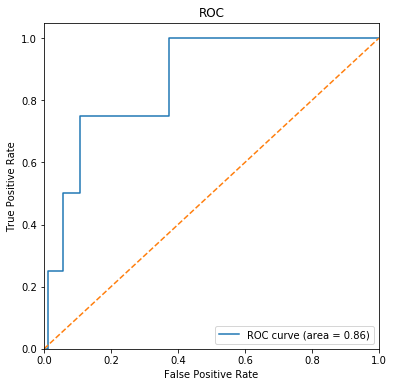

In [56]:
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

In [58]:
result.sort_values('score', ascending=False)

,score,predict,real,correct
298,-8.618878,0,0,True
270,-11.265733,0,0,True
198,-12.318450,0,0,True
257,-13.052779,0,0,True
154,-16.499258,0,1,False
311,-18.147539,0,0,True
151,-19.703488,0,0,True
200,-20.123662,0,0,True
75,-23.578232,0,0,True
11,-24.499969,0,0,True
